<a href="https://colab.research.google.com/github/crabsim/Arduino_codes/blob/master/Mob_net_animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.python.keras.utils.layer_utils import count_params
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline
print(tf.__version__)

2.7.0


In [ ]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
train_path = 'data/train'
valid_path = 'data/validation'
test_path = 'data/test'

In [ ]:
rm -r /content/data/train


In [ ]:
!unrar x "/content/train.rar" "/content/data/"

Streaming output truncated to the last 5000 lines.
Extracting  /content/data/train/spiders/ea37b50b2cf5023ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  OK 
Extracting  /content/data/train/spiders/ea37b60c2df0073ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  OK 
Extracting  /content/data/train/spiders/ea37b80629f7023ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  OK 
Extracting  /content/data/train/spiders/ea37b8082df4093ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  OK 
Extracting  /content/data/train/spiders/ea37b80f2bf1013ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  OK 
Extracting  /content/data/train/spiders/ea37b9062bf7053ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  OK 
Extracting  /content/data/train/spiders/ea37b9072af7043ed1584d05fb1d4e9fe777ead218ac104497f5c97ca5edb3bd_640.jpg      73%  O

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 13412 images belonging to 6 classes.
Found 2549 images belonging to 6 classes.
Found 1845 images belonging to 6 classes.


In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()


17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
image_size = 224
IMG_SHAPE = (image_size, image_size, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False



In [ ]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(6, activation='softmax')])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)

In [ ]:
epochs = 50
steps_per_epoch = 30
validation_steps = 30
history = model.fit_generator(train_batches,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=valid_batches,
                              validation_steps=validation_steps)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/50
30/30 [==============================] - 18s 616ms/step - loss: 0.2719 - accuracy: 0.9700 - val_loss: 0.3312 - val_accuracy: 0.9300
Epoch 2/50
30/30 [==============================] - 19s 647ms/step - loss: 0.3177 - accuracy: 0.9367 - val_loss: 0.2783 - val_accuracy: 0.9433
Epoch 3/50
30/30 [==============================] - 20s 656ms/step - loss: 0.2812 - accuracy: 0.9467 - val_loss: 0.2456 - val_accuracy: 0.9533
Epoch 4/50
30/30 [==============================] - 20s 659ms/step - loss: 0.2602 - accuracy: 0.9433 - val_loss: 0.2346 - val_accuracy: 0.9367
Epoch 5/50
30/30 [==============================] - 19s 637ms/step - loss: 0.2303 - accuracy: 0.9467 - val_loss: 0.2083 - val_accuracy: 0.9533
Epoch 6/50
30/30 [==============================] - 19s 654ms/step - loss: 0.2411 - accuracy: 0.9500 - val_loss: 0.2500 - val_accuracy: 0.9333
Epoch 7/50
30/30 [==============================] - 19s 629ms/step - loss: 0.2145 - accuracy: 0.9533 - val_loss: 0.2102 - val_accuracy: 0.9467

In [ ]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [ ]:
def test_single_image(path):
    #displaying images
    img = read_image(path)
    print(img)
    plt.imshow(img)
    #initializing the model to predict the image details using predefined models.
    resizedimg = image.img_to_array(img)
    finalimg = np.expand_dims(resizedimg,axis=0)
    finalimg = tf.keras.applications.mobilenet_v2.preprocess_input(finalimg)
    finalimg.shape
    predictions = model.predict(finalimg)
      
    # To predict and decode the image details
    results = imagenet_utils.decode_predictions(predictions)
    print(results)   

In [ ]:
Model.save(model, r'a.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
path = '/content/data/train/butterflies/OIP--3xxJkezSkNzxrQaxlhv-QHaHa.jpeg'

In [ ]:
path1='data/test/butterears2.jpg'

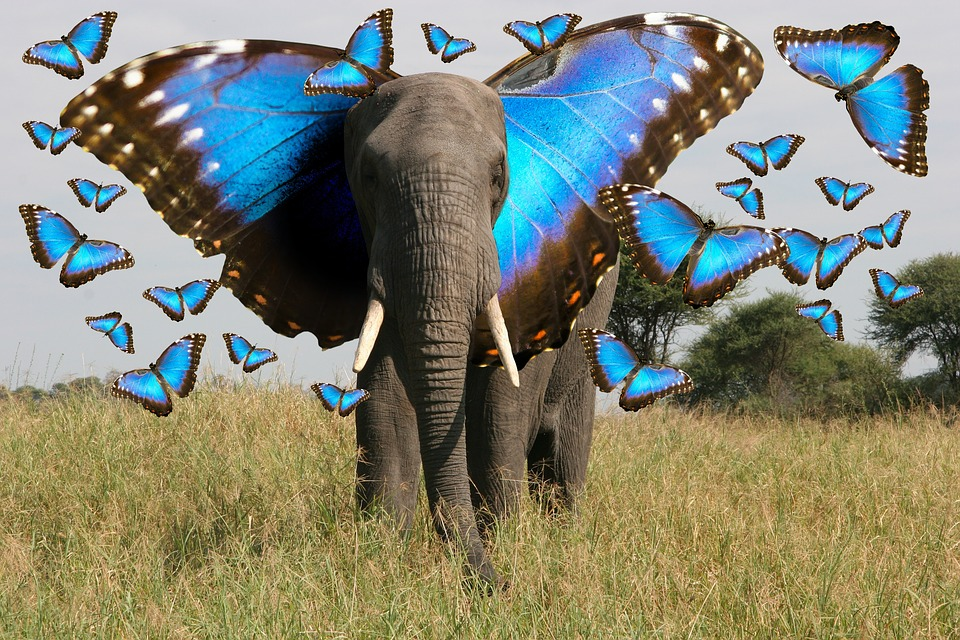

In [ ]:
from IPython.display import Image
Image(path1)

In [ ]:
# test_single_image(path)

preprocessed_image = read_image(path1)
predictions1 = model.predict(preprocessed_image)
treetypearray = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
print("The predictions are: \n")
for i in range(0,5):
    print(treetypearray[i],": ",round(predictions1[0,i], 6))

predictions1

[INFO] loading and preprocessing image...
The predictions are: 

butterflies :  0.227011
chickens :  0.002639
elephants :  0.740444
horses :  0.022525
spiders :  0.007135


array([[2.2701095e-01, 2.6394939e-03, 7.4044412e-01, 2.2525121e-02,
        7.1352227e-03, 2.4499555e-04]], dtype=float32)

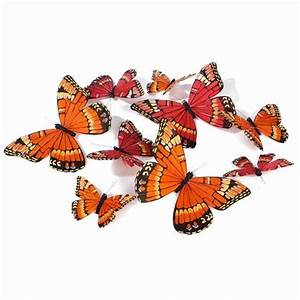

In [ ]:
from IPython.display import Image
Image(path)

In [ ]:
preprocessed_image = read_image(path)
predictions1 = model.predict(preprocessed_image)
treetypearray = ['butterflies', 'chickens', 'elephants', 'horses', 'spiders', 'squirells']
print("The predictions are: \n")
for i in range(0,5):
    print(treetypearray[i],": ",round(predictions1[0,i], 6))

predictions1

[INFO] loading and preprocessing image...
The predictions are: 

butterflies :  0.882586
chickens :  0.047067
elephants :  0.00255
horses :  0.006603
spiders :  0.047321


array([[0.88258636, 0.04706693, 0.00254994, 0.00660325, 0.04732101,
        0.01387263]], dtype=float32)